[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VilohitT/llm-thought-tracing/blob/main/notebooks/mathematical_reasoning_notebook.ipynb)

# ## Setup and Dependencies

In [1]:
# Install required packages
!pip install transformer-lens matplotlib seaborn numpy torch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 55.3 MB/s eta 0:00:

In [2]:
# Clone the repo
!git clone https://github.com/VilohitT/llm-thought-tracing.git

%cd llm-thought-tracing

Cloning into 'llm-thought-tracing'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 342 (delta 0), reused 0 (delta 0), pack-reused 341 (from 1)
Receiving objects: 100% (342/342), 31.91 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/llm-thought-tracing


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from transformer_lens import HookedTransformer
from IPython.display import display, Markdown, HTML
import matplotlib.animation as animation
import warnings

from llm_reasoning_tracer.concept_extraction import extract_concept_activations
from llm_reasoning_tracer.reasoning_analysis import analyze_reasoning_paths
from llm_reasoning_tracer.causal_intervention import perform_causal_intervention
from llm_reasoning_tracer.visualization import (
    plot_concept_activation_heatmap,
    animate_concept_activation_diagonal,
    animate_reasoning_flow,
    animate_reasoning_flow_dark,
    plot_layer_position_intervention,
    save_animation
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## Load the Model

We'll use the Llama 3.2-3B-Instruct model, which provides a good balance between performance and computational requirements.


In [4]:
from google.colab import userdata
from huggingface_hub import login

hf_key = userdata.get('hf_key')
login(hf_key)

In [ ]:
def load_llama_3_2():
    return HookedTransformer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct", device="cuda")

model = load_llama_3_2()
print(f"Loaded model: {model.cfg.model_name}")
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Number of attention heads: {model.cfg.n_heads}")
print(f"Hidden size: {model.cfg.d_model}")

model.cfg.use_attn_result = True

### 🧠 Multi-Step Arithmetic Reasoning: 2 + 4 → 6 → 6 × 5 → 30


In [6]:
# Define the prompt
math_prompt = "2 plus 4, multiplied by 5 is "

# Define potential intermediate and final concepts
math_intermediates = ["2", "4", "6", "5"]
math_finals = ["30"]

# Define potential reasoning paths
math_paths = [
    ["6", "30"],                   # Direct intermediate → result path
    ["2", "4", "6", "5", "30"],    # Full step-by-step path
    ["2", "4", "5", "30"]          # Incorrect path (skipping proper intermediate)
]

# Display the prompt and reasoning path
display(Markdown(f"**Prompt:** {math_prompt}"))
display(Markdown(f"**Expected reasoning path:** 6 → 30"))

**Prompt:** 2 plus 4, multiplied by 5 is 

**Expected reasoning path:** 6 → 30

In [7]:
# First, let's check if the model gets the correct answer
tokens = model.to_str_tokens(math_prompt)
logits = model(math_prompt)
final_pos = len(tokens) - 1

# Get top predictions
probs = torch.softmax(logits[0, final_pos], dim=0)
top_vals, top_indices = torch.topk(probs, k=5)
top_tokens = [model.to_single_str_token(idx.item()) for idx in top_indices]
top_probs = top_vals.cpu().detach().numpy()

# Display top predictions
display(Markdown("### Model's top predictions:"))
for token, prob in zip(top_tokens, top_probs):
    display(Markdown(f"- **{token}**: {prob:.4f}"))

### Model's top predictions:

- **30**: 0.1993

- **2**: 0.0801

- **22**: 0.0510

- **26**: 0.0448

- **20**: 0.0445

### 📊 Step 1: Extracting Concept Activations

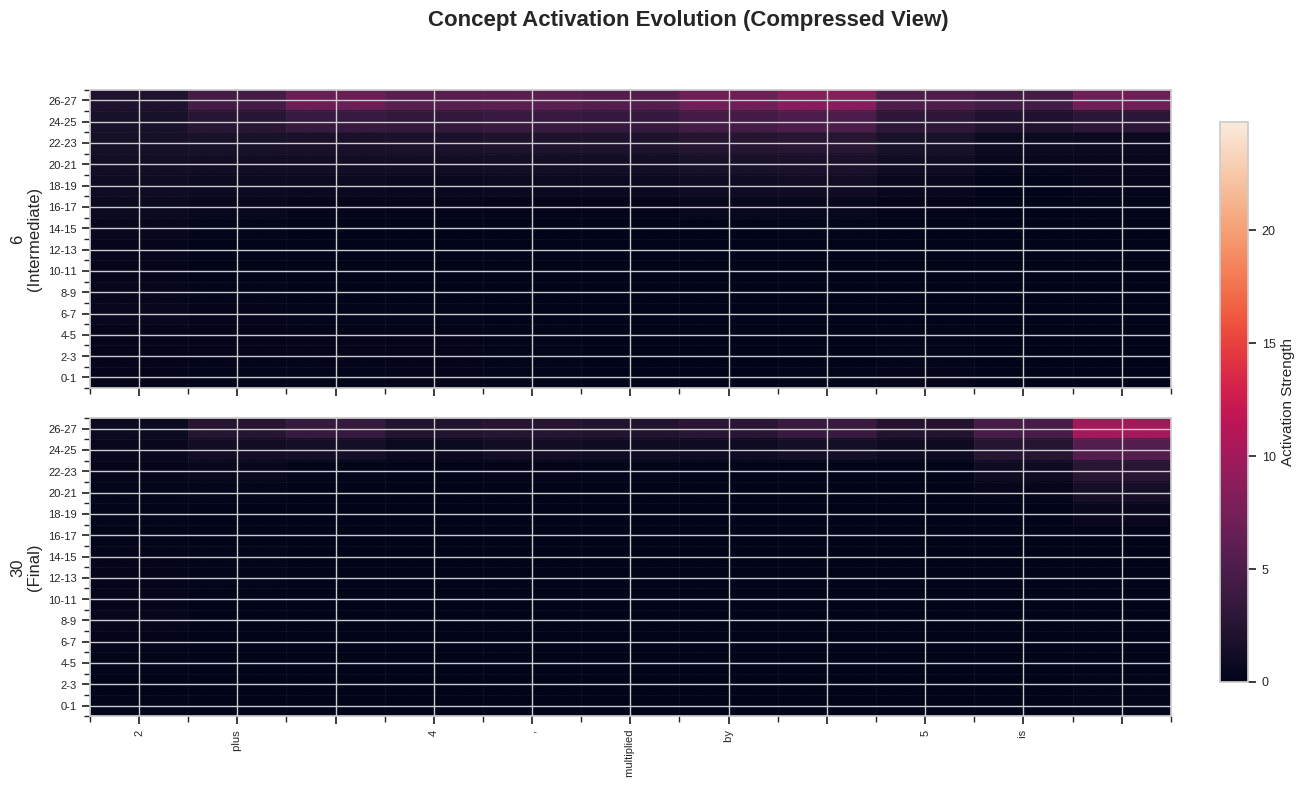

<Figure size 640x480 with 0 Axes>

In [8]:
# Extract concept activations
math_concept_results = extract_concept_activations(
    model,
    math_prompt,
    intermediate_concepts=math_intermediates,
    final_concepts=math_finals,
    logit_threshold=0.05
)

# Visualize concept evolution
fig6 = plot_concept_activation_heatmap(math_concept_results, selected_concepts=["6", "30"])
plt.tight_layout()
fig6.savefig("figures/math_concept_evolution.png", dpi=300, bbox_inches='tight')
display(fig6)

### 🔍 Interpretation of Concept Activation Heatmaps


In [9]:
# Animate concept activation for 6
ani = animate_concept_activation_diagonal(math_concept_results, selected_concepts=["6"])
display(display(HTML(ani.to_jshtml())))
ani.save("figures/6_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

None

In [10]:
# Animate concept activation for 30
ani = animate_concept_activation_diagonal(math_concept_results, selected_concepts=["30"])
display(display(HTML(ani.to_jshtml())))
ani.save("figures/30_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

None

### 🔄 Step 3: Analyzing Reasoning Path Structure


In [11]:
# Analyze reasoning paths
math_path_results = analyze_reasoning_paths(
    model,
    math_prompt,
    potential_paths=math_paths,
    concept_threshold=0.05
)

# Print path scores
display(Markdown("### Reasoning Path Scores:"))
for path_data in math_path_results["path_scores"]:
    path = path_data["path"]
    score = path_data["score"]
    complete = path_data.get("complete", False)
    in_order = path_data.get("in_order", False)

    path_str = " → ".join(path)
    status = ""
    if not complete:
        status = "(Missing concepts)"
    elif not in_order:
        status = "(Out of order)"

    display(Markdown(f"- **{path_str}**: {score:.4f} {status}"))

# Print best path
if math_path_results["best_path"]:
    best_path = " → ".join(math_path_results["best_path"])
    display(Markdown(f"**Best path:** {best_path} (score: {math_path_results['best_path_score']:.4f})"))

### Reasoning Path Scores:

- **6 → 30**: 1.0000 

- **2 → 4 → 6 → 5 → 30**: 1.0000 

- **2 → 4 → 5 → 30**: 1.0000 

**Best path:** 6 → 30 (score: 1.0000)

### 🎬 Step 4: Visualizing the Full Reasoning Trajectory

In [12]:
tokens = model.to_str_tokens(math_prompt)

# Visualize reasoning path analysis
anim  = animate_reasoning_flow(
    math_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers
)
display(HTML(anim.to_jshtml()))

In [13]:
anim = save_animation(
    path_results=math_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers,
    output_path="figures/reasoning_flow_math_dark.gif",
    format="gif",
    fps=1,
    dpi=300
)

Animation saved to figures/reasoning_flow_math_dark.gif


### 🧠 Step 5: Causal Tracing – How Does Corruption Affect the Model's Belief?


In [14]:
# Perform causal intervention on key tokens
math_intervention_results = perform_causal_intervention(
    model,
    math_prompt,
    concepts=["30"],
    target_positions=[2]     # "plus" corrupted with "minus"
)

# Print top influential tokens for the final answer
display(Markdown("### Most Influential Tokens for '30':"))
for i, influence in enumerate(math_intervention_results["token_importance"]["30"][:5]):
    display(Markdown(f"- **{influence['token']}** (position {influence['position']}): Effect = {influence['effect']:.4f}"))

### Most Influential Tokens for '30':

- ** plus** (position 2): Effect = 1.8845

### 🔬 Visualizing Causal Influence Across Layers and Positions


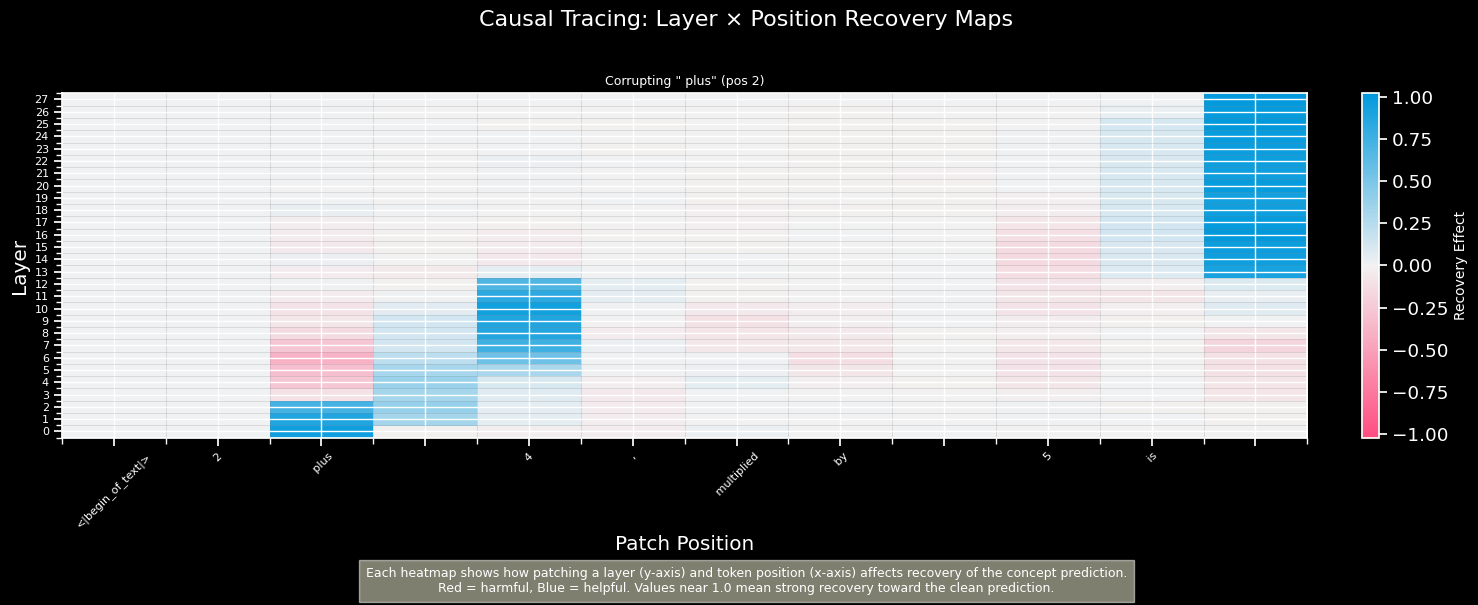

<Figure size 640x480 with 0 Axes>

In [15]:
# Visualize causal intervention
fig7 = plot_layer_position_intervention(math_intervention_results)
plt.tight_layout()
fig7.savefig("figures/math_causal_intervention.png", dpi=300, bbox_inches='tight')
display(fig7)